### Imports and Definitions

In [1]:
from copy import copy
from gzip import open as gopen
from matplotlib import rcParams
from matplotlib.patches import Patch
from pickle import load,dump
from scipy.stats import kendalltau
from seaborn import lineplot,pointplot,set_context,set_style
import matplotlib.pyplot as plt
EART = r'E_{ART}'
ED = r'E_{d}'
avg = lambda x: sum(x)/len(x)

### Helper Functions to Kendall’s Tau Test

In [2]:
# compute the Kendall's tau
def tau(om):
    t,p = kendalltau(om, list(range(len(om)-1,-1,-1))) # p is 2-sided
    return (t,p/2.)

# returns (stat,p,stat_dist)
def tau_test(om,side,bg=None,it=1000):
    assert side in {'left','right'}, "'side' must be 'left' or 'right'"
    t,p = tau(om)
    if bg is None:
        tau_dist = list()
        for _ in range(it):
            tmp = om[:]; shuffle(tmp); tau_dist.append(tau(tmp)[0])
    else:
        tau_dist = bg
    #if side == 'right':
    #    p = sum(e >= t for e in tau_dist)/len(tau_dist)
    #elif side == 'left':
    #    p = sum(e <= t for e in tau_dist)/len(tau_dist)
    return t,p,tau_dist

### Aesthetics

In [3]:
RC = {
    "font.size":12,
    "axes.titlesize":16,
    "axes.labelsize":14,
    "legend.fontsize":10,
    "xtick.labelsize":12,
    "ytick.labelsize":12
}

meta = {
    'color': {
        'avg_clade': '#00FF00',
        'expected': '#000000',
        'hivtrace': '#880000',
        'max': '#000088',
        'max_clade': '#0000FF',
        'single_linkage': '#FF0000',
        'sum_branch': '#008800',
        'sum_branch_clade': '#00FF00',
    },

    'label': {
        'avg_clade': 'Average-Diameter (Clade)',
        'expected': 'Expected',
        'hivtrace': 'HIV-TRACE',
        'max': 'Max-Diameter',
        'max_clade': 'Max-Diameter (Clade)',
        'single_linkage': 'Single-Linkage',
        'sum_branch': 'Sum-Length',
        'sum_branch_clade': 'Sum-Length (Clade)',
    },

    'linestyle': {
        'avg_clade': '-',
        'expected': '--',
        'hivtrace': ':',
        'max': '-',
        'max_clade': '-',
        'single_linkage': '-',
        'sum_branch': '-',
        'sum_branch_clade': '-',
    }
}

set_context("paper", rc=RC)
set_style("ticks")
rcParams['font.family'] = 'serif'

### Effectiveness vs. ART and Expected Degree (default threshold) and Number of Clusters (different thresholds)

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


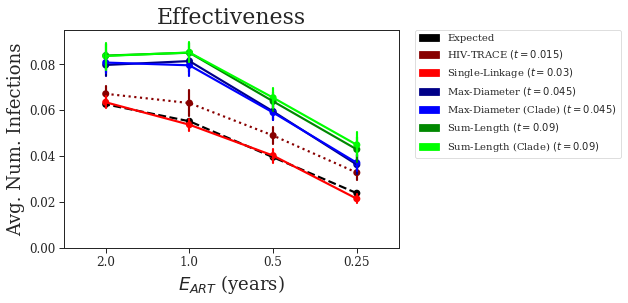

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


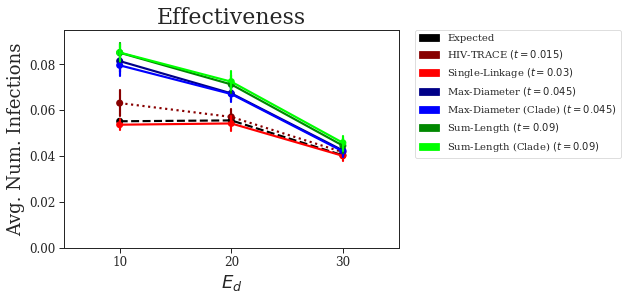

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


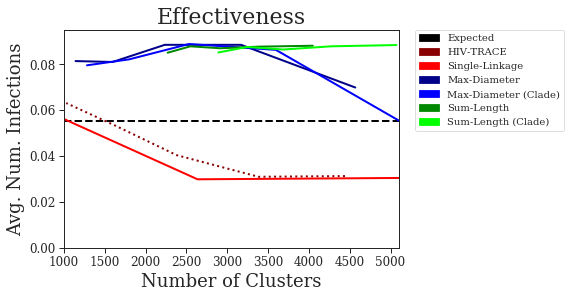

In [4]:
default_threshold = {
    'expected': None,
    'hivtrace': 0.015,
    'single_linkage': 0.03,
    'max': 0.045,
    'max_clade': 0.045,
    'sum_branch': 0.09,
    'sum_branch_clade': 0.09,
}
eff_order = ['expected','hivtrace','single_linkage','max','max_clade','sum_branch','sum_branch_clade']
eff_handles = [Patch(color=meta['color'][m], label=meta['label'][m]) for m in eff_order]
eff_handles_with_thresh = list()
for m in eff_order:
    if m == 'expected':
        eff_handles_with_thresh.append(Patch(color=meta['color'][m], label=meta['label'][m]))
    else:
        eff_handles_with_thresh.append(Patch(color=meta['color'][m], label=r"%s $(t=%s)$"%(meta['label'][m],str(default_threshold[m]))))

eff_data = load(gopen('DATA.EFFECTIVENESS.pkl.gz'))
eff_ymax = 0.095 #max(e for d in eff_data for r in eff_data[d] for m in eff_data[d][r] for e in eff_data[d][r][m])

# Effectiveness vs. ART
fig = plt.figure()
for m in eff_order:
    x = list(); y = list(); t = default_threshold[m]
    for r in sorted(eff_data[m][10].keys()):
        y += eff_data[m][10][r][t]['efficacy']; x += [1./r]*len(eff_data[m][10][r][t]['efficacy'])
    ax = pointplot(x=x, y=y, color=meta['color'][m], linestyles=meta['linestyle'][m])
ax.invert_xaxis()
plt.ylim(ymin=0, ymax=eff_ymax)
plt.title("Effectiveness", size=22)
plt.xlabel(r"$%s$ (years)"%EART, size=18)
plt.ylabel("Avg. Num. Infections", size=18)
legend = plt.legend(handles=eff_handles_with_thresh,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=True)
plt.show()
fig.savefig('effectiveness_art.pdf', format='pdf', bbox_extra_artists=(legend,), bbox_inches='tight')
plt.close()

# Effectiveness vs. Expected Degree
fig = plt.figure()
for m in eff_order:
    x = list(); y = list(); t = default_threshold[m]
    for d in sorted(eff_data[m].keys()):
        y += eff_data[m][d][1][t]['efficacy']; x += [d]*len(eff_data[m][d][1][t]['efficacy'])
    ax = pointplot(x=x, y=y, color=meta['color'][m], linestyles=meta['linestyle'][m])
plt.ylim(ymin=0, ymax=eff_ymax)
plt.title("Effectiveness", size=22)
plt.xlabel(r"$%s$"%ED, size=18)
plt.ylabel("Avg. Num. Infections", size=18)
legend = plt.legend(handles=eff_handles_with_thresh,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=True)
plt.show()
fig.savefig('effectiveness_degree.pdf', format='pdf', bbox_extra_artists=(legend,), bbox_inches='tight')
plt.close()

# Effectiveness vs. Number of Clusters
xmin = 1000 #1029
xmax = 5100 #4442
fig = plt.figure()
for m in eff_order:
    if m == 'expected':
        x = [xmin-1,xmax+1]; y = [avg(eff_data[m][10][1][None]['efficacy'])]*2
    else:
        x = list(); y = list()
        for t in eff_data[m][10][1]:
        #    y += eff_data[m][10][1][t]['efficacy']; x += [avg(eff_data[m][10][1][t]['num_clusters'])]*len(eff_data[m][10][1][t]['efficacy'])
            x.append(avg(eff_data[m][10][1][t]['num_clusters']))
            y.append(avg(eff_data[m][10][1][t]['efficacy']))
    plt.plot(x, y, color=meta['color'][m], linestyle=meta['linestyle'][m], linewidth=2)
plt.xlim(xmin=xmin, xmax=xmax)
plt.ylim(ymin=0, ymax=eff_ymax)
plt.title("Effectiveness", size=22)
plt.xlabel("Number of Clusters", size=18)
plt.ylabel("Avg. Num. Infections", size=18)
legend = plt.legend(handles=eff_handles,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=True)
plt.show()
fig.savefig('effectiveness_clusters.pdf', format='pdf', bbox_extra_artists=(legend,), bbox_inches='tight')
plt.close()
set_context("paper", rc=RC)

### Effectiveness vs. All Model Conditions

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


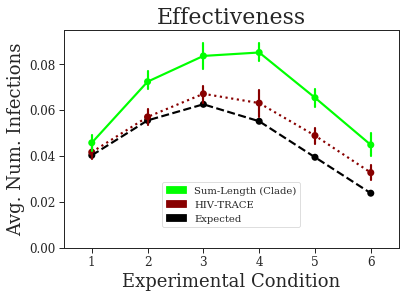

In [5]:
eff_allcond_order = ['expected','hivtrace','sum_branch_clade']
eff_allcond_handles = [Patch(color=meta['color'][m], label=meta['label'][m]) for m in eff_allcond_order][::-1]
key_tuples = [(30,1), (20,1), (10,0.5), (10,1), (10,2), (10,4)]
fig = plt.figure()
for m in eff_allcond_order:
    x = list(); y = list(); t = default_threshold[m]
    for i,tup in enumerate(key_tuples):
        y += eff_data[m][tup[0]][tup[1]][t]['efficacy']; x += [i+1]*len(eff_data[m][tup[0]][tup[1]][t]['efficacy'])
    ax = pointplot(x=x, y=y, color=meta['color'][m], linestyles=meta['linestyle'][m])
plt.ylim(ymin=0, ymax=eff_ymax)
plt.title("Effectiveness", size=22)
plt.xlabel("Experimental Condition", size=18)
plt.ylabel("Avg. Num. Infections", size=18)
legend = plt.legend(handles=eff_allcond_handles,bbox_to_anchor=(0.5, 0.3), loc=9, borderaxespad=0., frameon=True)
plt.show()
fig.savefig('effectiveness_conditions.pdf', format='pdf', bbox_extra_artists=(legend,), bbox_inches='tight')
plt.close()

### Use Thresholds Yielding 3000 Clusters

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


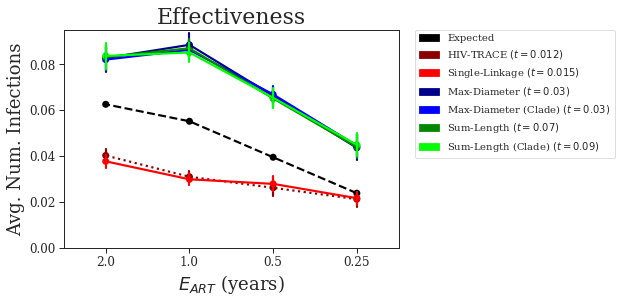

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


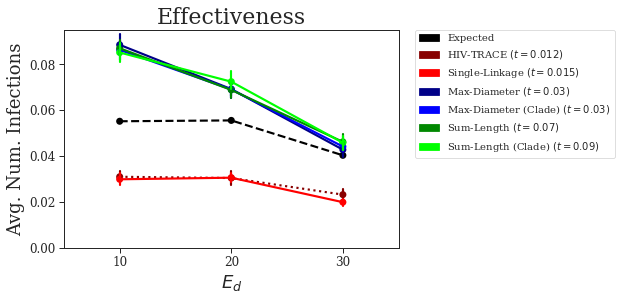

In [6]:
default_threshold = {
    'expected': None,
    'hivtrace': 0.012,
    'single_linkage': 0.015,
    'max': 0.03,
    'max_clade': 0.03,
    'sum_branch': 0.07,
    'sum_branch_clade': 0.09,
}
eff_order = ['expected','hivtrace','single_linkage','max','max_clade','sum_branch','sum_branch_clade']
eff_handles = [Patch(color=meta['color'][m], label=meta['label'][m]) for m in eff_order]
eff_handles_with_thresh = list()
for m in eff_order:
    if m == 'expected':
        eff_handles_with_thresh.append(Patch(color=meta['color'][m], label=meta['label'][m]))
    else:
        eff_handles_with_thresh.append(Patch(color=meta['color'][m], label=r"%s $(t=%s)$"%(meta['label'][m],str(default_threshold[m]))))

eff_data = load(gopen('DATA.EFFECTIVENESS.pkl.gz'))
eff_ymax = 0.095 #max(e for d in eff_data for r in eff_data[d] for m in eff_data[d][r] for e in eff_data[d][r][m])

# Effectiveness vs. ART
fig = plt.figure()
for m in eff_order:
    x = list(); y = list(); t = default_threshold[m]
    for r in sorted(eff_data[m][10].keys()):
        y += eff_data[m][10][r][t]['efficacy']; x += [1./r]*len(eff_data[m][10][r][t]['efficacy'])
    ax = pointplot(x=x, y=y, color=meta['color'][m], linestyles=meta['linestyle'][m])
ax.invert_xaxis()
plt.ylim(ymin=0, ymax=eff_ymax)
plt.title("Effectiveness", size=22)
plt.xlabel(r"$%s$ (years)"%EART, size=18)
plt.ylabel("Avg. Num. Infections", size=18)
legend = plt.legend(handles=eff_handles_with_thresh,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=True)
plt.show()
fig.savefig('effectiveness_art_3000clusters.pdf', format='pdf', bbox_extra_artists=(legend,), bbox_inches='tight')
plt.close()

# Effectiveness vs. Expected Degree
fig = plt.figure()
for m in eff_order:
    x = list(); y = list(); t = default_threshold[m]
    for d in sorted(eff_data[m].keys()):
        y += eff_data[m][d][1][t]['efficacy']; x += [d]*len(eff_data[m][d][1][t]['efficacy'])
    ax = pointplot(x=x, y=y, color=meta['color'][m], linestyles=meta['linestyle'][m])
plt.ylim(ymin=0, ymax=eff_ymax)
plt.title("Effectiveness", size=22)
plt.xlabel(r"$%s$"%ED, size=18)
plt.ylabel("Avg. Num. Infections", size=18)
legend = plt.legend(handles=eff_handles_with_thresh,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=True)
plt.show()
fig.savefig('effectiveness_degree_3000clusters.pdf', format='pdf', bbox_extra_artists=(legend,), bbox_inches='tight')
plt.close()
set_context("paper", rc=RC)